tensorflow version

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2024-12-08 10:40:03.256299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.12.0


if use GPUs

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

load MNIST fashion dataset

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

load classes

In [4]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

plot sample image

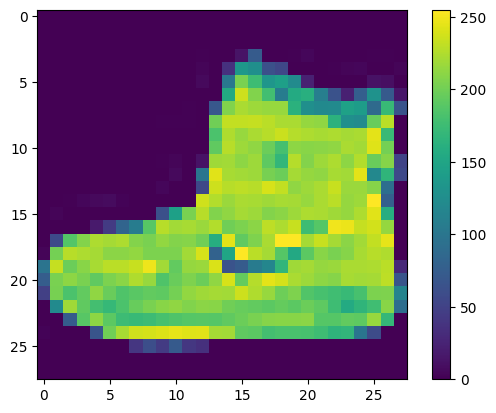

In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

preprocess datasets

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

train_labels = train_labels / 1.0
train_labels = np.expand_dims(train_labels, -1)
test_labels = test_labels / 1.0
test_labels = np.expand_dims(test_labels, -1)

implementation of model

In [7]:
import numpy as np
from tensorflow.keras.layers import MultiHeadAttention

def positional_encoding(length, depth):
    depth = depth/2
    
    positions = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth
    
    angle_rates = 1/(10000 ** depths)
    angle_rads = positions * angle_rates
    
    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis =-1
    )
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, length, d_model):
    super().__init__()
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(length, d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding(length=length, depth=d_model)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x
  
def positional_encoding_2D(length, width, depth):
    depth = depth/4
    
    pos_x = np.arange(width)[:, np.newaxis]
    pos_y = np.arange(length)[:, np.newaxis]
    depths = np.arange(depth)[np.newaxis, :]/depth
    
    angle_rates = 1/(10000 ** depths)
    angle_rads_x = pos_x * angle_rates
    angle_rads_y = pos_y * angle_rates
    
    pos_encoding_x = np.concatenate(
        [np.sin(angle_rads_x), np.cos(angle_rads_x)],
        axis =-1
    )
    pos_encoding_x = tf.expand_dims(pos_encoding_x, 1)
    
    pos_encoding_y = np.concatenate(
        [np.sin(angle_rads_y), np.cos(angle_rads_y)],
        axis = -1
    )
    
    pos_encoding_y = tf.expand_dims(pos_encoding_y, 0)
    
    pos_encoding_x = tf.tile(pos_encoding_x, (1, length, 1))
    pos_encoding_y = tf.tile(pos_encoding_y, (width, 1, 1))
    pos_encoding = tf.concat([pos_encoding_x, pos_encoding_y], -1)
    
    return tf.cast(pos_encoding, dtype=tf.float32)

class PositionalEmbedding2D(tf.keras.layers.Layer):
  def __init__(self, length, width, d_model):
    super().__init__()
    self.length = length
    self.width = width
    self.input_dim = length * width
    self.d_model = d_model
    self.embedding = tf.keras.layers.Embedding(input_dim=self.input_dim, output_dim=d_model, mask_zero=True) 
    self.pos_encoding = positional_encoding_2D(length=length, width=width, depth=d_model)


  def call(self, x):
    x = self.embedding(x)
    
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :self.length, :self.width, :]
    return x
  
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = MultiHeadAttention(**kwargs)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()
        
class CrossAttention(BaseAttention):
    def call(self, x, context):
        
        if len(context.shape) == 4:
            context = tf.reduce_mean(context, axis=(1, 2), keepdims=True)
            context = tf.squeeze(context, axis=1)
        att_output, att_scores = self.mha(query=x,
                                          key=context,
                                          value=context,
                                          return_attention_scores=True)
        
        self.last_att_scores = att_scores
        x = self.add([x, att_output])
        x = self.layer_norm(x)
        
        return x
    
class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        
        att_output = self.mha(query=x,
                              key=x,
                              value=x)

        x = self.add([x, att_output])
        x = self.layer_norm(x)
        
        return x
    
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        att_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask=True
        )
        x = self.add([x, att_output])
        x = self.layer_norm(x)
        return x
    
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
        
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x
    
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, num_heads, dff, dropout_rate=0.1):
        super().__init__()
        
        self.self_attention = GlobalSelfAttention(
            num_heads=num_heads,
            key_dim=dff,
            dropout=dropout_rate
        )
        
        self.ffn = FeedForward(dff)
        
    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x
    
class Encoder(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_layers, 
                 num_heads, 
                 dff, 
                 length,
                 width,
                 dropout_rate=0.1):
        super().__init__()
        
        self.num_layers = num_layers
        
        self.pos_embedding =PositionalEmbedding2D(length, width, dff)
        
        self.enc_layers = [
            EncoderLayer(num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
    def call(self, x):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x)
        return x
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                 *,
                 num_heads,
                 dff,
                 dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
       
        self.causal_self_attention = CausalSelfAttention(
            num_heads=num_heads,
            key_dim=dff,
            dropout=dropout_rate
        )
        
        self.cross_attention = CrossAttention(
            num_heads=num_heads,
            key_dim = dff,
            dropout=dropout_rate
        )
        
        self.ffn = FeedForward(dff)
        
    def call(self, x, context):
        x = self.causal_self_attention(x=x)
        x = self.cross_attention(x=x, context=context)
        self.last_att_scores = self.cross_attention.last_att_scores
    
        x = self.ffn(x)
        return x
    
class Decoder(tf.keras.layers.Layer):
    def __init__(self, 
                 *,
                 num_layers,
                 num_heads,
                 dff,
                 num_cat,
                 dropout_rate=0.1):
        super(Decoder, self).__init__()
        
        self.num_layers =num_layers
        
        self.pos_embedding =PositionalEmbedding(
            num_cat,
            dff
        )
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayer(num_heads=num_heads,
                         dff=dff,
                         dropout_rate=dropout_rate)
            for _ in range(num_layers)
        ]
        self.last_att_scores = None
        
    def call(self, x, context):
        x = self.pos_embedding(x)
        x = self.dropout(x)
        
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, context)
        
        self.last_att_scores = self.dec_layers[-1].last_att_scores
        
        return x
    
class Transformer(tf.keras.Model):
    def __init__(self,
                 *,
                 num_layers,
                 num_heads,
                 dff,
                 length,
                 width,
                 num_cat,
                 dropout_rate=0.1):
        super().__init__()
        self.encoder = Encoder(
            num_layers=num_layers,
            num_heads=num_heads,
            dff=dff,
            length=length,
            width=width,
            dropout_rate=dropout_rate
        )
        self.decoder = Decoder(
            num_layers=num_layers,
            num_heads=num_heads,
            dff=dff,
            num_cat=num_cat,
            dropout_rate=dropout_rate
        )
        self.final_layer = tf.keras.layers.Dense(num_cat)
    
    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        x = self.decoder(x, context)
        logits = self.final_layer(x)
        
        return logits

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

def masked_loss(label, pred):
  
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss


def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

build model

In [8]:
transformer = Transformer(
    num_layers=6,
    num_heads=4,
    dff=16,
    length=28,
    width=28,
    num_cat=10,
    dropout_rate=0.1
)
dff = 16
learning_rate = CustomSchedule(dff)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)
'''
transformer.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])
'''
transformer.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

train model

In [9]:
transformer.fit((train_images, train_labels), train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 15580s 8s/step - loss: 0.1127 - accuracy: 0.9737
Epoch 2/5
1875/1875 [==============================] - 15407s 8s/step - loss: 0.0066 - accuracy: 0.9985
Epoch 3/5
1875/1875 [==============================] - 15364s 8s/step - loss: 0.0017 - accuracy: 0.9997
Epoch 4/5
1875/1875 [==============================] - 15370s 8s/step - loss: 0.0037 - accuracy: 0.9992
Epoch 5/5
1875/1875 [==============================] - 15383s 8s/step - loss: 0.0025 - accuracy: 0.9992


test model

In [10]:
test_loss, test_acc = transformer.evaluate((test_images, test_labels), test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

313/313 - 1111s - loss: 2.1484e-05 - accuracy: 1.0000 - 1111s/epoch - 4s/step

Test accuracy: 1.0
